Initializing CUDA...
CUDA initialization complete
Loading library: ./cuda_matlib.so
Function signatures configured
Initializing CUDA resources (one-time operation)...
CUDA resources initialized
Running transformer demo with d_model=512, d_ff=2048
Benchmarking with batch_size=8, seq_len=512
  Tensor Cores: 0.0225s (573.38 GFLOPS)
  Standard: 0.1664s (77.44 GFLOPS)
  Speedup: 7.40x
Benchmarking with batch_size=8, seq_len=1024
  Tensor Cores: 0.0400s (858.47 GFLOPS)
  Standard: 0.3737s (91.95 GFLOPS)
  Speedup: 9.34x
Benchmarking with batch_size=8, seq_len=2048
  Tensor Cores: 0.1030s (1001.22 GFLOPS)
  Standard: 0.9065s (113.71 GFLOPS)
  Speedup: 8.81x
Benchmarking with batch_size=8, seq_len=4096
  Tensor Cores: 0.2734s (1256.59 GFLOPS)
  Standard: 2.4856s (138.24 GFLOPS)
  Speedup: 9.09x
Benchmarking with batch_size=16, seq_len=512
  Tensor Cores: 0.0431s (597.98 GFLOPS)
  Standard: 0.3304s (77.99 GFLOPS)
  Speedup: 7.67x
Benchmarking with batch_size=16, seq_len=1024
  Tensor Cores: 0.0

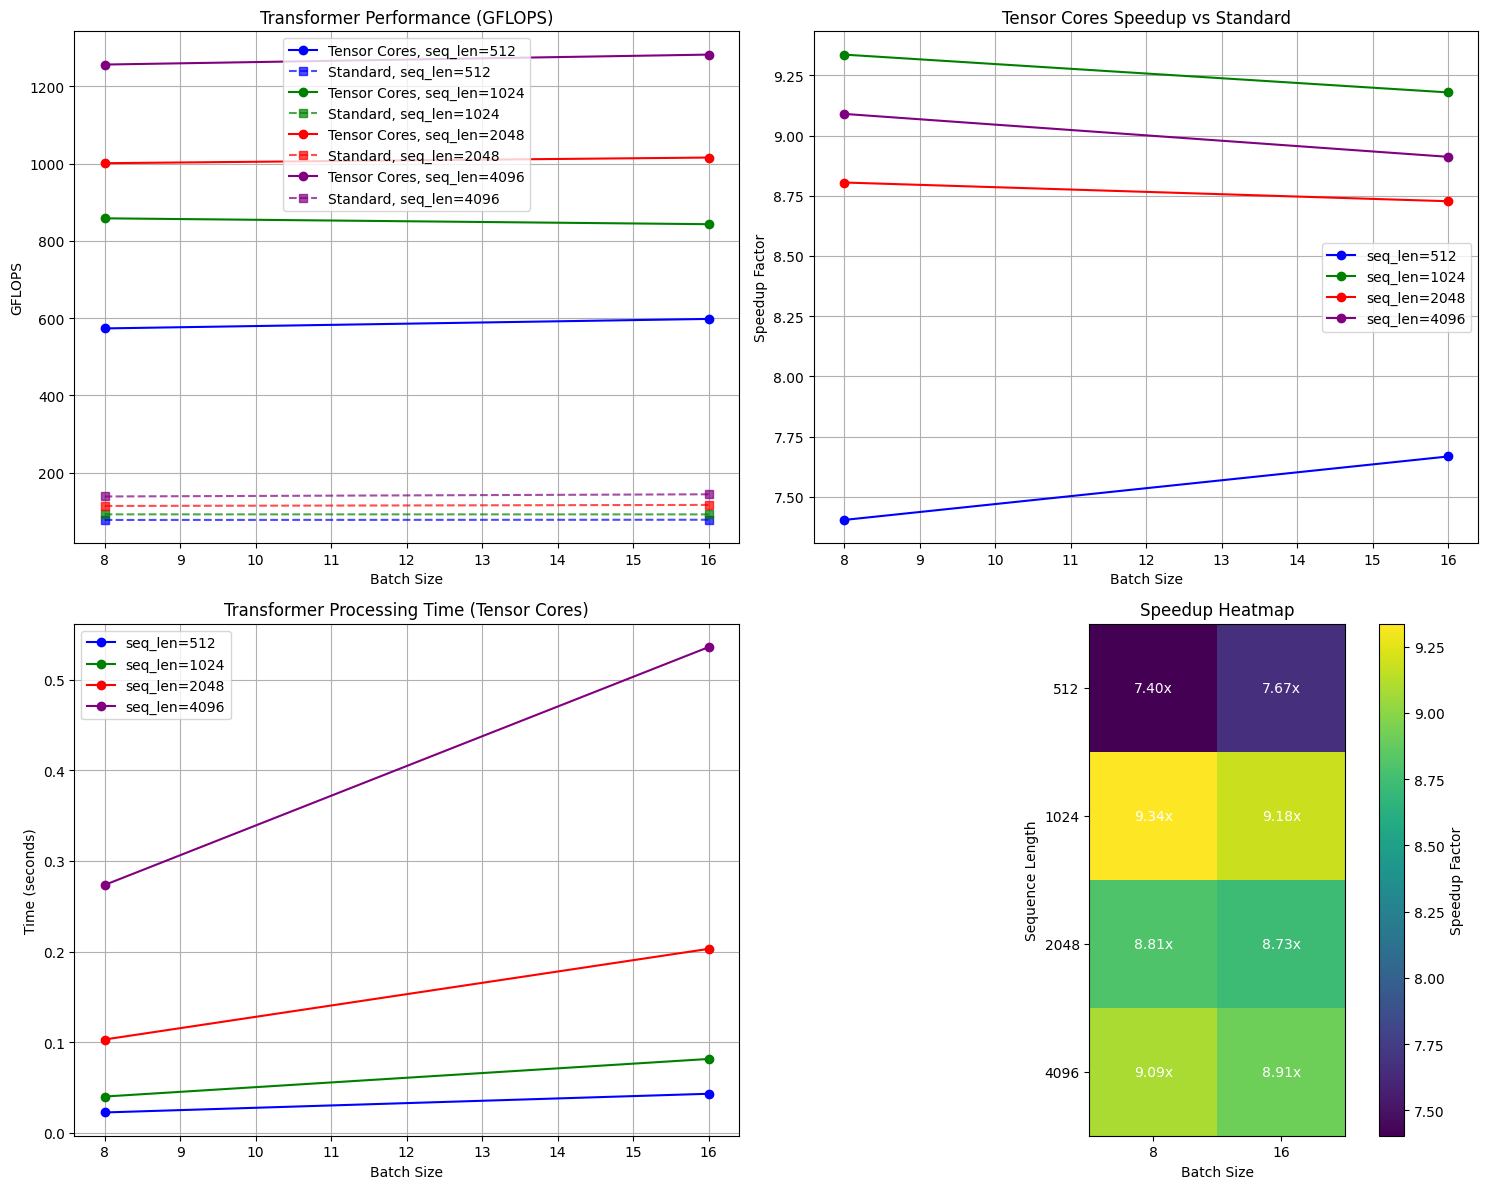


Summary:
Batch=8, Seq=512: 7.40x speedup, 573.38 GFLOPS
Batch=8, Seq=1024: 9.34x speedup, 858.47 GFLOPS
Batch=8, Seq=2048: 8.81x speedup, 1001.22 GFLOPS
Batch=8, Seq=4096: 9.09x speedup, 1256.59 GFLOPS
Batch=16, Seq=512: 7.67x speedup, 597.98 GFLOPS
Batch=16, Seq=1024: 9.18x speedup, 843.25 GFLOPS
Batch=16, Seq=2048: 8.73x speedup, 1015.78 GFLOPS
Batch=16, Seq=4096: 8.91x speedup, 1282.37 GFLOPS


In [2]:
import numpy as np
import cupy as cp
import time
import matplotlib.pyplot as plt
from tensor_matrix_ops import TensorMatrixOps

class SimpleTransformerDemo:
    """A simple demonstration of a transformer encoder using tensor cores."""
    
    def __init__(self, use_tensor_cores=True):
        """Initialize the transformer demo.
        
        Args:
            use_tensor_cores: Whether to use tensor cores for matrix operations
        """
        self.use_tensor_cores = use_tensor_cores
        if self.use_tensor_cores:
            self.tensor_ops = TensorMatrixOps()
    
    def _matmul(self, x, y):
        """Matrix multiplication with or without tensor cores."""
        if self.use_tensor_cores:
            return self.tensor_ops.matmul(x, y)
        else:
            return cp.matmul(x, y)
    
    def _softmax(self, x, axis=-1):
        """Compute softmax values for the last dimension."""
        x_max = cp.max(x, axis=axis, keepdims=True)
        exp_x = cp.exp(x - x_max)
        return exp_x / cp.sum(exp_x, axis=axis, keepdims=True)
    
    def _layer_norm(self, x, epsilon=1e-6):
        """Apply layer normalization."""
        mean = cp.mean(x, axis=-1, keepdims=True)
        variance = cp.mean((x - mean) ** 2, axis=-1, keepdims=True)
        return (x - mean) / cp.sqrt(variance + epsilon)
    
    def self_attention(self, q, k, v, mask=None):
        """Compute self-attention.
        
        Args:
            q: Query tensor [batch_size, seq_len, d_model]
            k: Key tensor [batch_size, seq_len, d_model]
            v: Value tensor [batch_size, seq_len, d_model]
            mask: Optional mask tensor
            
        Returns:
            Output tensor [batch_size, seq_len, d_model]
        """
        # Process each batch separately to avoid broadcasting issues
        batch_size, seq_len, d_model = q.shape
        output = cp.zeros((batch_size, seq_len, d_model), dtype=q.dtype)
        
        for i in range(batch_size):
            # Compute attention scores: [seq_len, seq_len]
            scores = self._matmul(q[i], k[i].T)
            
            # Scale scores
            scores = scores / cp.sqrt(d_model)
            
            # Apply mask if provided
            if mask is not None:
                scores = scores + mask
            
            # Apply softmax
            weights = self._softmax(scores)
            
            # Apply attention weights
            output[i] = self._matmul(weights, v[i])
        
        return output
    
    def feed_forward(self, x, w1, w2):
        """Apply feed-forward network.
        
        Args:
            x: Input tensor [batch_size, seq_len, d_model]
            w1: First weight matrix [d_model, d_ff]
            w2: Second weight matrix [d_ff, d_model]
            
        Returns:
            Output tensor [batch_size, seq_len, d_model]
        """
        # Process each example separately to use tensor cores effectively
        batch_size, seq_len, d_model = x.shape
        d_ff = w1.shape[1]
        output = cp.zeros((batch_size, seq_len, d_model), dtype=x.dtype)
        
        for i in range(batch_size):
            # Flatten sequence dimension
            flat_x = x[i].reshape(-1, d_model)
            
            # First linear layer
            hidden = self._matmul(flat_x, w1)
            
            # ReLU activation
            hidden = cp.maximum(0, hidden)
            
            # Second linear layer
            flat_output = self._matmul(hidden, w2)
            
            # Reshape back
            output[i] = flat_output.reshape(seq_len, d_model)
        
        return output
    
    def transformer_encoder_layer(self, x, qkv_weight, o_weight, ff1_weight, ff2_weight):
        """Apply a transformer encoder layer.
        
        Args:
            x: Input tensor [batch_size, seq_len, d_model]
            qkv_weight: Combined Q/K/V weight matrix [d_model, 3*d_model]
            o_weight: Output projection matrix [d_model, d_model]
            ff1_weight: First feed-forward weight matrix [d_model, d_ff]
            ff2_weight: Second feed-forward weight matrix [d_ff, d_model]
            
        Returns:
            Output tensor [batch_size, seq_len, d_model]
        """
        batch_size, seq_len, d_model = x.shape
        
        # Multi-head attention block
        residual = x
        
        # Layer normalization
        x_norm = self._layer_norm(x)
        
        # Process each batch separately for QKV projections
        qkv = cp.zeros((batch_size, seq_len, 3 * d_model), dtype=x.dtype)
        for i in range(batch_size):
            # Flatten sequence dimension
            flat_x = x_norm[i].reshape(-1, d_model)
            
            # QKV projections
            qkv[i] = self._matmul(flat_x, qkv_weight).reshape(seq_len, 3 * d_model)
        
        # Split QKV
        q, k, v = cp.split(qkv, 3, axis=2)
        
        # Self-attention
        attn_output = self.self_attention(q, k, v)
        
        # Output projection
        attn_output_projected = cp.zeros_like(x)
        for i in range(batch_size):
            flat_attn = attn_output[i].reshape(-1, d_model)
            attn_output_projected[i] = self._matmul(flat_attn, o_weight).reshape(seq_len, d_model)
        
        # First residual connection
        x = residual + attn_output_projected
        
        # Feed-forward block
        residual = x
        
        # Layer normalization
        x_norm = self._layer_norm(x)
        
        # Feed-forward network
        ff_output = self.feed_forward(x_norm, ff1_weight, ff2_weight)
        
        # Second residual connection
        x = residual + ff_output
        
        return x
    
    def generate_sample_data(self, batch_size, seq_len, d_model, d_ff):
        """Generate sample data for the transformer.
        
        Args:
            batch_size: Batch size
            seq_len: Sequence length
            d_model: Model dimension
            d_ff: Feed-forward dimension
            
        Returns:
            Dictionary with sample data
        """
        # Input data
        x = cp.random.randn(batch_size, seq_len, d_model).astype(cp.float64)
        
        # Weights
        qkv_weight = cp.random.randn(d_model, 3 * d_model).astype(cp.float64) * 0.02
        o_weight = cp.random.randn(d_model, d_model).astype(cp.float64) * 0.02
        ff1_weight = cp.random.randn(d_model, d_ff).astype(cp.float64) * 0.02
        ff2_weight = cp.random.randn(d_ff, d_model).astype(cp.float64) * 0.02
        
        return {
            'x': x,
            'qkv_weight': qkv_weight,
            'o_weight': o_weight,
            'ff1_weight': ff1_weight,
            'ff2_weight': ff2_weight
        }
    
    def benchmark_transformer(self, batch_sizes=[4, 8], seq_lengths=[128, 256], d_model=512, d_ff=2048, repeats=3):
        """Benchmark the transformer encoder layer.
        
        Args:
            batch_sizes: List of batch sizes to test
            seq_lengths: List of sequence lengths to test
            d_model: Model dimension
            d_ff: Feed-forward dimension
            repeats: Number of times to repeat each test
            
        Returns:
            Dictionary with results
        """
        results = {}
        
        for batch_size in batch_sizes:
            results[batch_size] = {}
            
            for seq_len in seq_lengths:
                print(f"Benchmarking with batch_size={batch_size}, seq_len={seq_len}")
                
                # Generate sample data
                data = self.generate_sample_data(batch_size, seq_len, d_model, d_ff)
                
                # Benchmark with tensor cores
                self.use_tensor_cores = True
                tensor_times = []
                
                for _ in range(repeats):
                    start = time.time()
                    _ = self.transformer_encoder_layer(
                        data['x'], data['qkv_weight'], data['o_weight'],
                        data['ff1_weight'], data['ff2_weight']
                    )
                    cp.cuda.Stream.null.synchronize()
                    tensor_times.append(time.time() - start)
                
                # Benchmark without tensor cores
                self.use_tensor_cores = False
                standard_times = []
                
                for _ in range(repeats):
                    start = time.time()
                    _ = self.transformer_encoder_layer(
                        data['x'], data['qkv_weight'], data['o_weight'],
                        data['ff1_weight'], data['ff2_weight']
                    )
                    cp.cuda.Stream.null.synchronize()
                    standard_times.append(time.time() - start)
                
                # Calculate approximate FLOPS
                # Self-attention: ~4 * batch_size * seq_len * seq_len * d_model
                attn_flops = 4 * batch_size * seq_len * seq_len * d_model
                
                # Feed-forward: ~2 * batch_size * seq_len * d_model * d_ff
                ff_flops = 2 * batch_size * seq_len * d_model * d_ff
                
                total_flops = attn_flops + ff_flops
                tensor_gflops = total_flops / (1e9 * min(tensor_times))
                standard_gflops = total_flops / (1e9 * min(standard_times))
                speedup = min(standard_times) / min(tensor_times)
                
                results[batch_size][seq_len] = {
                    'tensor_time': min(tensor_times),
                    'standard_time': min(standard_times),
                    'tensor_gflops': tensor_gflops,
                    'standard_gflops': standard_gflops,
                    'speedup': speedup
                }
                
                print(f"  Tensor Cores: {min(tensor_times):.4f}s ({tensor_gflops:.2f} GFLOPS)")
                print(f"  Standard: {min(standard_times):.4f}s ({standard_gflops:.2f} GFLOPS)")
                print(f"  Speedup: {speedup:.2f}x")
                
                # Clear memory
                del data
                cp.get_default_memory_pool().free_all_blocks()
        
        return results
    
    def plot_results(self, results):
        """Plot benchmark results.
        
        Args:
            results: Results from benchmark_transformer
        """
        batch_sizes = list(results.keys())
        seq_lengths = list(results[batch_sizes[0]].keys())
        
        # Create figure with 2 rows and 2 columns
        fig, axes = plt.subplots(2, 2, figsize=(15, 12))
        
        # Colors for different sequence lengths
        colors = ['blue', 'green', 'red', 'purple', 'orange']
        
        # Plot GFLOPS vs Batch Size for each sequence length
        ax = axes[0, 0]
        for i, seq_len in enumerate(seq_lengths):
            tensor_gflops = [results[bs][seq_len]['tensor_gflops'] for bs in batch_sizes]
            standard_gflops = [results[bs][seq_len]['standard_gflops'] for bs in batch_sizes]
            
            ax.plot(batch_sizes, tensor_gflops, 'o-', color=colors[i], label=f'Tensor Cores, seq_len={seq_len}')
            ax.plot(batch_sizes, standard_gflops, 's--', color=colors[i], alpha=0.7, label=f'Standard, seq_len={seq_len}')
        
        ax.set_title('Transformer Performance (GFLOPS)')
        ax.set_xlabel('Batch Size')
        ax.set_ylabel('GFLOPS')
        ax.legend()
        ax.grid(True)
        
        # Plot Speedup vs Batch Size for each sequence length
        ax = axes[0, 1]
        for i, seq_len in enumerate(seq_lengths):
            speedups = [results[bs][seq_len]['speedup'] for bs in batch_sizes]
            ax.plot(batch_sizes, speedups, 'o-', color=colors[i], label=f'seq_len={seq_len}')
        
        ax.set_title('Tensor Cores Speedup vs Standard')
        ax.set_xlabel('Batch Size')
        ax.set_ylabel('Speedup Factor')
        ax.legend()
        ax.grid(True)
        
        # Plot Time vs Batch Size for each sequence length (tensor cores)
        ax = axes[1, 0]
        for i, seq_len in enumerate(seq_lengths):
            times = [results[bs][seq_len]['tensor_time'] for bs in batch_sizes]
            ax.plot(batch_sizes, times, 'o-', color=colors[i], label=f'seq_len={seq_len}')
        
        ax.set_title('Transformer Processing Time (Tensor Cores)')
        ax.set_xlabel('Batch Size')
        ax.set_ylabel('Time (seconds)')
        ax.legend()
        ax.grid(True)
        
        # Plot heatmap of speedups
        ax = axes[1, 1]
        speedups = np.array([[results[bs][seq_len]['speedup'] for bs in batch_sizes] for seq_len in seq_lengths])
        im = ax.imshow(speedups, cmap='viridis')
        
        # Add colorbar
        plt.colorbar(im, ax=ax, label='Speedup Factor')
        
        # Add labels
        ax.set_xticks(np.arange(len(batch_sizes)))
        ax.set_yticks(np.arange(len(seq_lengths)))
        ax.set_xticklabels(batch_sizes)
        ax.set_yticklabels(seq_lengths)
        ax.set_xlabel('Batch Size')
        ax.set_ylabel('Sequence Length')
        ax.set_title('Speedup Heatmap')
        
        # Add speedup values to the heatmap
        for i in range(len(seq_lengths)):
            for j in range(len(batch_sizes)):
                ax.text(j, i, f"{speedups[i, j]:.2f}x", 
                        ha="center", va="center", color="white" if speedups[i, j] > 1.5 else "black")
        
        plt.tight_layout()
        plt.savefig('transformer_demo_results.png', dpi=300)
        plt.show()
        
        return fig
    
    def run_demo(self, d_model=512, d_ff=2048):
        """Run the transformer demo.
        
        Args:
            d_model: Model dimension
            d_ff: Feed-forward dimension
            
        Returns:
            Dictionary with results
        """
        print(f"Running transformer demo with d_model={d_model}, d_ff={d_ff}")
        
        # Smaller sizes for faster benchmarking
        batch_sizes = [8, 16]
        seq_lengths = [512, 1024, 2048, 4096]
        
        # Run benchmark
        results = self.benchmark_transformer(
            batch_sizes=batch_sizes,
            seq_lengths=seq_lengths,
            d_model=d_model,
            d_ff=d_ff,
            repeats=2  # Fewer repeats for faster benchmarking
        )
        
        # Plot results
        self.plot_results(results)
        
        # Print summary
        print("\nSummary:")
        for batch_size in batch_sizes:
            for seq_len in seq_lengths:
                speedup = results[batch_size][seq_len]['speedup']
                tensor_gflops = results[batch_size][seq_len]['tensor_gflops']
                
                print(f"Batch={batch_size}, Seq={seq_len}: {speedup:.2f}x speedup, {tensor_gflops:.2f} GFLOPS")
        
        return results

if __name__ == "__main__":
    demo = SimpleTransformerDemo()
    results = demo.run_demo()

Initializing CUDA...
CUDA initialization complete
Loading library: ./cuda_matlib.so
Function signatures configured
Initializing CUDA resources (one-time operation)...
CUDA resources initialized
Initializing model with hidden_size=768
Generating 20 tokens with tensor cores...


Generating tokens: 100%|██████████| 20/20 [00:00<00:00, 36.81it/s]


Generating 20 tokens without tensor cores...


Generating tokens: 100%|██████████| 20/20 [00:02<00:00,  8.01it/s]



Results Summary:
  Tensor Cores: 36.97 tokens/sec
  Standard: 8.04 tokens/sec
  Speedup: 4.60x


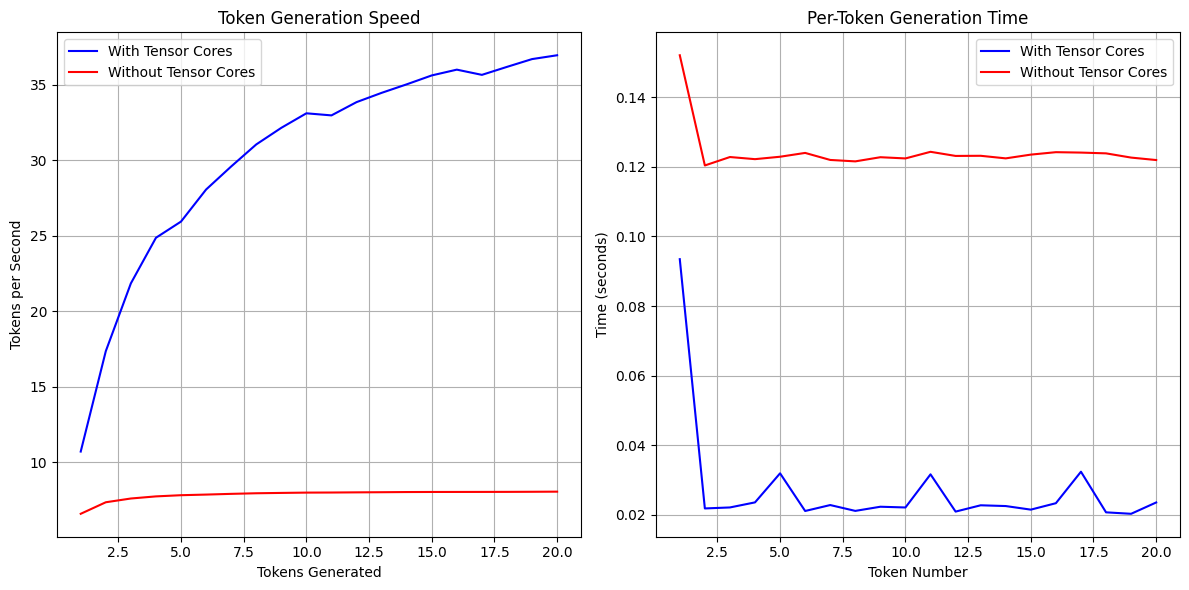

In [1]:
import numpy as np
import cupy as cp
import time
import matplotlib.pyplot as plt
from tqdm import tqdm
from tensor_matrix_ops import TensorMatrixOps

class TransformerTokenDemo:
    """Demonstration of tensor cores impact on token generation speed."""
    
    def __init__(self, use_tensor_cores=True):
        """Initialize the demo with or without tensor cores."""
        self.use_tensor_cores = use_tensor_cores
        if self.use_tensor_cores:
            self.tensor_ops = TensorMatrixOps()
    
    def _matmul(self, a, b):
        """Matrix multiplication with or without tensor cores."""
        if self.use_tensor_cores:
            return self.tensor_ops.matmul(a, b)
        else:
            return cp.matmul(a, b)
    
    def _gelu(self, x):
        """Approximate GELU activation function."""
        return 0.5 * x * (1 + cp.tanh(cp.sqrt(2 / np.pi) * (x + 0.044715 * cp.power(x, 3))))
    
    def _softmax(self, x, axis=-1):
        """Compute softmax along specified axis."""
        x_max = cp.max(x, axis=axis, keepdims=True)
        exp_x = cp.exp(x - x_max)
        return exp_x / cp.sum(exp_x, axis=axis, keepdims=True)
    
    def _layer_norm(self, x, gamma, beta, eps=1e-5):
        """Apply layer normalization."""
        mean = cp.mean(x, axis=-1, keepdims=True)
        var = cp.var(x, axis=-1, keepdims=True)
        return gamma * (x - mean) / cp.sqrt(var + eps) + beta
    
    def initialize_model(self, hidden_size=512, num_heads=8, 
                         intermediate_size=2048, vocab_size=50000):
        """Initialize a simple transformer model for token generation."""
        # Store model dimensions
        self.hidden_size = hidden_size
        self.num_heads = num_heads
        self.head_size = hidden_size // num_heads
        self.intermediate_size = intermediate_size
        self.vocab_size = vocab_size
        
        # Initialize weights with appropriate scaling
        scale = 0.02
        
        # Embedding weights
        self.embedding = cp.random.normal(0, scale, (vocab_size, hidden_size)).astype(cp.float64)
        
        # Self-attention weights
        self.query = cp.random.normal(0, scale, (hidden_size, hidden_size)).astype(cp.float64)
        self.key = cp.random.normal(0, scale, (hidden_size, hidden_size)).astype(cp.float64)
        self.value = cp.random.normal(0, scale, (hidden_size, hidden_size)).astype(cp.float64)
        self.out_proj = cp.random.normal(0, scale, (hidden_size, hidden_size)).astype(cp.float64)
        
        # Feed-forward weights
        self.ff1 = cp.random.normal(0, scale, (hidden_size, intermediate_size)).astype(cp.float64)
        self.ff2 = cp.random.normal(0, scale, (intermediate_size, hidden_size)).astype(cp.float64)
        
        # Layer norm weights
        self.ln1_gamma = cp.ones(hidden_size, dtype=cp.float64)
        self.ln1_beta = cp.zeros(hidden_size, dtype=cp.float64)
        self.ln2_gamma = cp.ones(hidden_size, dtype=cp.float64)
        self.ln2_beta = cp.zeros(hidden_size, dtype=cp.float64)
        self.ln_f_gamma = cp.ones(hidden_size, dtype=cp.float64)
        self.ln_f_beta = cp.zeros(hidden_size, dtype=cp.float64)
        
        # Output projection
        self.lm_head = cp.random.normal(0, scale, (hidden_size, vocab_size)).astype(cp.float64)
    
    def forward(self, input_ids, position=0, max_tokens=10):
        """Generate tokens with the model.
        
        Args:
            input_ids: Input token ids [batch_size, seq_len]
            position: Starting position for generation
            max_tokens: Maximum number of tokens to generate
            
        Returns:
            Generated token ids and timing information
        """
        batch_size, seq_len = input_ids.shape
        generated_tokens = []
        token_times = []
        running_tokens_per_second = []
        
        # Initial embedding lookup
        hidden_states = cp.zeros((batch_size, seq_len, self.hidden_size), dtype=cp.float64)
        for b in range(batch_size):
            for s in range(seq_len):
                if input_ids[b, s] < self.vocab_size:
                    hidden_states[b, s] = self.embedding[input_ids[b, s]]
        
        # Context encoding with tqdm progress bar for visualization
        for i in tqdm(range(max_tokens), desc="Generating tokens"):
            start_time = time.time()
            
            # Only compute for the current position
            pos = position + i
            if pos >= hidden_states.shape[1]:
                # Extend hidden states if needed
                hidden_states = cp.concatenate([
                    hidden_states, 
                    cp.zeros((batch_size, 1, self.hidden_size), dtype=cp.float64)
                ], axis=1)
            
            # Get hidden state for current position
            current_hidden = hidden_states[:, :pos+1]  # Include all previous tokens for attention
            
            # Self-attention
            # (Compute for all positions but only use the last one)
            attention_output = self._self_attention_block(current_hidden)
            
            # Get only the last position output
            last_hidden = attention_output[:, -1:, :]
            
            # Feed-forward
            ffn_output = self._feed_forward_block(last_hidden)
            
            # Final layer norm
            normed_output = self._layer_norm(ffn_output, self.ln_f_gamma, self.ln_f_beta)
            
            # Language model head
            for b in range(batch_size):
                # Compute logits for this batch
                logits = self._matmul(normed_output[b], self.lm_head)
                
                # Get most probable next token (simple greedy decoding)
                next_token = cp.argmax(logits[0]).item()
                generated_tokens.append(next_token)
                
                # Store new token embedding
                if pos + 1 < hidden_states.shape[1]:
                    hidden_states[b, pos+1] = self.embedding[next_token]
            
            # Record timing
            token_time = time.time() - start_time
            token_times.append(token_time)
            running_tokens_per_second.append((i + 1) / sum(token_times))
        
        return {
            'tokens': generated_tokens,
            'times': token_times,
            'tokens_per_second': running_tokens_per_second
        }
    
    def _self_attention_block(self, hidden_states):
        """Process a self-attention block."""
        batch_size, seq_len, _ = hidden_states.shape
        
        # Layer norm
        normed_hidden = self._layer_norm(hidden_states, self.ln1_gamma, self.ln1_beta)
        
        # Project to q, k, v
        q_out = cp.zeros((batch_size, seq_len, self.hidden_size), dtype=cp.float64)
        k_out = cp.zeros((batch_size, seq_len, self.hidden_size), dtype=cp.float64)
        v_out = cp.zeros((batch_size, seq_len, self.hidden_size), dtype=cp.float64)
        
        for b in range(batch_size):
            q_out[b] = self._matmul(normed_hidden[b], self.query)
            k_out[b] = self._matmul(normed_hidden[b], self.key)
            v_out[b] = self._matmul(normed_hidden[b], self.value)
        
        # Compute attention scores
        attn_output = cp.zeros((batch_size, seq_len, self.hidden_size), dtype=cp.float64)
        
        for b in range(batch_size):
            # (seq_len, seq_len)
            attn_scores = self._matmul(q_out[b], k_out[b].T) / cp.sqrt(self.head_size)
            
            # Apply causal mask (autoregressive generation)
            mask = cp.tril(cp.ones((seq_len, seq_len), dtype=cp.float64))
            attn_scores = cp.where(mask == 0, -1e10, attn_scores)
            
            # Apply softmax
            attn_probs = self._softmax(attn_scores, axis=-1)
            
            # Apply attention weights
            context = self._matmul(attn_probs, v_out[b])
            attn_output[b] = context
        
        # Output projection
        output = cp.zeros_like(attn_output)
        for b in range(batch_size):
            output[b] = self._matmul(attn_output[b], self.out_proj)
        
        # Residual connection
        return hidden_states + output
    
    def _feed_forward_block(self, hidden_states):
        """Process a feed-forward block."""
        batch_size, seq_len, _ = hidden_states.shape
        
        # Layer norm
        normed_hidden = self._layer_norm(hidden_states, self.ln2_gamma, self.ln2_beta)
        
        # First linear layer + GELU
        intermediate = cp.zeros((batch_size, seq_len, self.intermediate_size), dtype=cp.float64)
        for b in range(batch_size):
            intermediate[b] = self._matmul(normed_hidden[b], self.ff1)
        
        # Apply GELU activation
        intermediate = self._gelu(intermediate)
        
        # Second linear layer
        output = cp.zeros((batch_size, seq_len, self.hidden_size), dtype=cp.float64)
        for b in range(batch_size):
            output[b] = self._matmul(intermediate[b], self.ff2)
        
        # Residual connection
        return hidden_states + output
    
    def benchmark_generation(self, batch_size=1, seq_length=128, 
                           gen_tokens=50, hidden_size=512):
        """Benchmark token generation speed.
        
        Args:
            batch_size: Number of sequences to generate
            seq_length: Initial sequence length
            gen_tokens: Number of tokens to generate
            hidden_size: Model hidden size
            
        Returns:
            Comparison results for tensor cores and standard implementation
        """
        # Initialize model
        print(f"Initializing model with hidden_size={hidden_size}")
        self.initialize_model(hidden_size=hidden_size)
        
        # Create random input
        input_ids = cp.random.randint(0, self.vocab_size, (batch_size, seq_length))
        
        # Generate with tensor cores
        self.use_tensor_cores = True
        print(f"Generating {gen_tokens} tokens with tensor cores...")
        tensor_results = self.forward(input_ids, seq_length-1, gen_tokens)
        
        # Generate without tensor cores
        self.use_tensor_cores = False
        print(f"Generating {gen_tokens} tokens without tensor cores...")
        standard_results = self.forward(input_ids, seq_length-1, gen_tokens)
        
        # Calculate overall tokens per second
        tensor_tokens_per_sec = gen_tokens / sum(tensor_results['times'])
        standard_tokens_per_sec = gen_tokens / sum(standard_results['times'])
        speedup = tensor_tokens_per_sec / standard_tokens_per_sec
        
        print(f"\nResults Summary:")
        print(f"  Tensor Cores: {tensor_tokens_per_sec:.2f} tokens/sec")
        print(f"  Standard: {standard_tokens_per_sec:.2f} tokens/sec")
        print(f"  Speedup: {speedup:.2f}x")
        
        # Plot results
        self.plot_comparison(tensor_results, standard_results)
        
        return {
            'tensor': tensor_results,
            'standard': standard_results,
            'speedup': speedup
        }
    
    def plot_comparison(self, tensor_results, standard_results):
        """Plot token generation speed comparison."""
        plt.figure(figsize=(12, 6))
        
        # Plot tokens per second (cumulative)
        plt.subplot(1, 2, 1)
        x = range(1, len(tensor_results['tokens_per_second']) + 1)
        plt.plot(x, tensor_results['tokens_per_second'], 'b-', label='With Tensor Cores')
        plt.plot(x, standard_results['tokens_per_second'], 'r-', label='Without Tensor Cores')
        plt.title('Token Generation Speed')
        plt.xlabel('Tokens Generated')
        plt.ylabel('Tokens per Second')
        plt.grid(True)
        plt.legend()
        
        # Plot individual token generation times
        plt.subplot(1, 2, 2)
        plt.plot(x, tensor_results['times'], 'b-', label='With Tensor Cores')
        plt.plot(x, standard_results['times'], 'r-', label='Without Tensor Cores')
        plt.title('Per-Token Generation Time')
        plt.xlabel('Token Number')
        plt.ylabel('Time (seconds)')
        plt.grid(True)
        plt.legend()
        
        plt.tight_layout()
        plt.savefig('token_generation_comparison.png', dpi=300)
        plt.show()

if __name__ == "__main__":
    # Create demo
    demo = TransformerTokenDemo()
    
    # Run benchmark with smaller parameters for faster execution
    results = demo.benchmark_generation(
        batch_size=1,         # Generate one sequence
        seq_length=2048,       # Start with a short sequence
        gen_tokens=20,        # Generate a small number of tokens
        hidden_size=768       # Medium-sized model
    )

Initializing CUDA...
CUDA initialization complete
Loading library: ./cuda_matlib.so
Function signatures configured
Initializing CUDA resources (one-time operation)...
CUDA resources initialized

=== Testing sequence length: 512 ===
Initializing model with hidden_size=768
Generating 5 tokens with tensor cores...


Generating tokens: 100%|██████████| 5/5 [00:00<00:00, 37.06it/s]


Generating 5 tokens without tensor cores...


Generating tokens: 100%|██████████| 5/5 [00:00<00:00, 33.20it/s]


Results for seq_len=512:
  Tensor Cores: 37.22 tokens/sec
  Standard: 33.35 tokens/sec
  Speedup: 1.12x

=== Testing sequence length: 1024 ===
Initializing model with hidden_size=768
Generating 5 tokens with tensor cores...


Generating tokens: 100%|██████████| 5/5 [00:00<00:00, 68.74it/s]


Generating 5 tokens without tensor cores...


Generating tokens: 100%|██████████| 5/5 [00:00<00:00, 22.49it/s]


Results for seq_len=1024:
  Tensor Cores: 68.86 tokens/sec
  Standard: 22.55 tokens/sec
  Speedup: 3.05x

=== Testing sequence length: 2048 ===
Initializing model with hidden_size=768
Generating 5 tokens with tensor cores...


Generating tokens: 100%|██████████| 5/5 [00:00<00:00, 36.08it/s]


Generating 5 tokens without tensor cores...


Generating tokens: 100%|██████████| 5/5 [00:00<00:00,  8.11it/s]


Results for seq_len=2048:
  Tensor Cores: 36.22 tokens/sec
  Standard: 8.15 tokens/sec
  Speedup: 4.45x

=== Testing sequence length: 4096 ===
Initializing model with hidden_size=768
Generating 5 tokens with tensor cores...


Generating tokens: 100%|██████████| 5/5 [00:00<00:00, 21.51it/s]


Generating 5 tokens without tensor cores...


Generating tokens: 100%|██████████| 5/5 [00:01<00:00,  2.68it/s]


Results for seq_len=4096:
  Tensor Cores: 21.57 tokens/sec
  Standard: 2.68 tokens/sec
  Speedup: 8.04x

=== Testing sequence length: 7192 ===
Initializing model with hidden_size=768
Generating 5 tokens with tensor cores...


Generating tokens: 100%|██████████| 5/5 [00:00<00:00,  7.15it/s]


Generating 5 tokens without tensor cores...


Generating tokens: 100%|██████████| 5/5 [00:04<00:00,  1.03it/s]


Results for seq_len=7192:
  Tensor Cores: 7.17 tokens/sec
  Standard: 1.03 tokens/sec
  Speedup: 6.94x


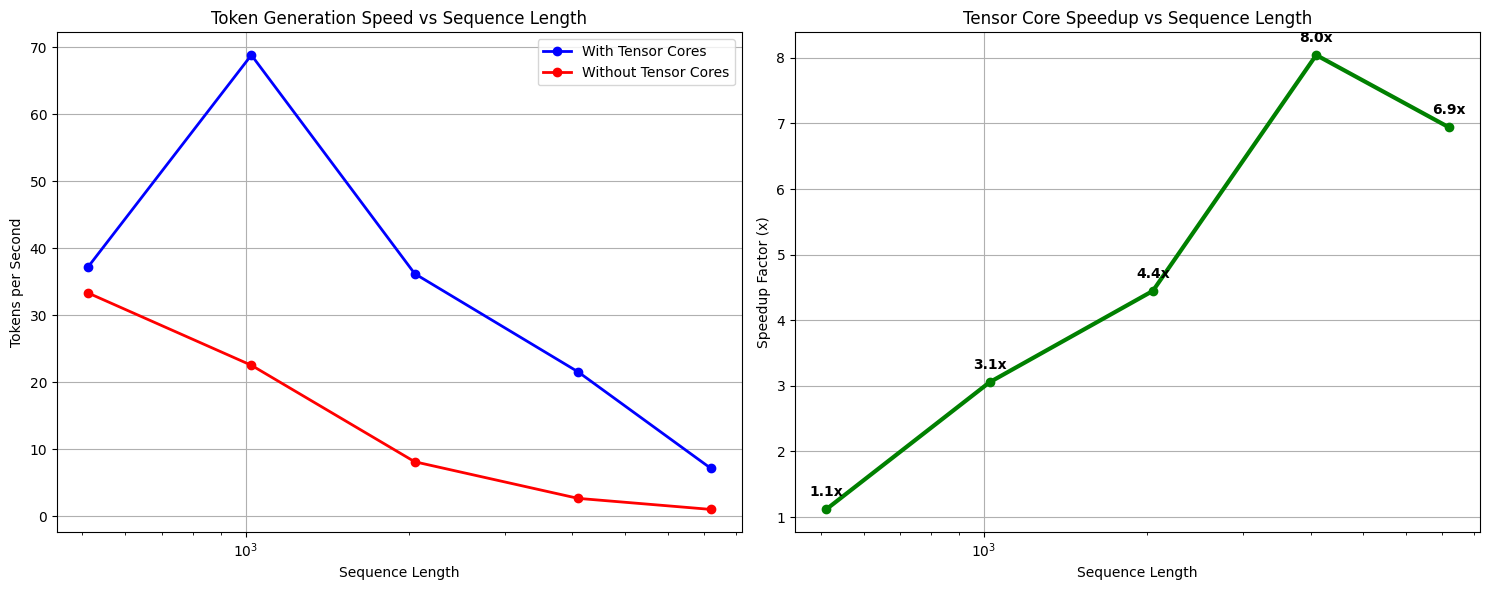

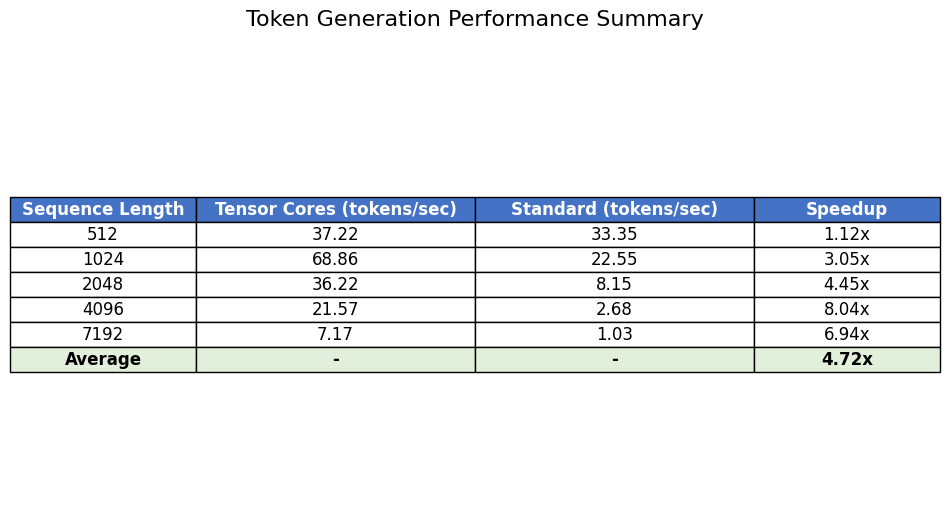


Final Summary:
Sequence Length 512: 1.12x speedup
Sequence Length 1024: 3.05x speedup
Sequence Length 2048: 4.45x speedup
Sequence Length 4096: 8.04x speedup
Sequence Length 7192: 6.94x speedup


In [1]:
import numpy as np
import cupy as cp
import time
import matplotlib.pyplot as plt
from tqdm import tqdm
from tensor_matrix_ops import TensorMatrixOps

class TransformerTokenScalingDemo:
    """Demonstration of tensor cores impact on token generation speed across sequence lengths."""
    
    def __init__(self, use_tensor_cores=True):
        """Initialize the demo with or without tensor cores."""
        self.use_tensor_cores = use_tensor_cores
        if self.use_tensor_cores:
            self.tensor_ops = TensorMatrixOps()
    
    def _matmul(self, a, b):
        """Matrix multiplication with or without tensor cores."""
        if self.use_tensor_cores:
            return self.tensor_ops.matmul(a, b)
        else:
            return cp.matmul(a, b)
    
    def _gelu(self, x):
        """Approximate GELU activation function."""
        return 0.5 * x * (1 + cp.tanh(cp.sqrt(2 / np.pi) * (x + 0.044715 * cp.power(x, 3))))
    
    def _softmax(self, x, axis=-1):
        """Compute softmax along specified axis."""
        x_max = cp.max(x, axis=axis, keepdims=True)
        exp_x = cp.exp(x - x_max)
        return exp_x / cp.sum(exp_x, axis=axis, keepdims=True)
    
    def _layer_norm(self, x, gamma, beta, eps=1e-5):
        """Apply layer normalization."""
        mean = cp.mean(x, axis=-1, keepdims=True)
        var = cp.var(x, axis=-1, keepdims=True)
        return gamma * (x - mean) / cp.sqrt(var + eps) + beta
    
    def initialize_model(self, hidden_size=512, num_heads=8, 
                         intermediate_size=2048, vocab_size=50000):
        """Initialize a simple transformer model for token generation."""
        # Store model dimensions
        self.hidden_size = hidden_size
        self.num_heads = num_heads
        self.head_size = hidden_size // num_heads
        self.intermediate_size = intermediate_size
        self.vocab_size = vocab_size
        
        # Initialize weights with appropriate scaling
        scale = 0.02
        
        # Embedding weights
        self.embedding = cp.random.normal(0, scale, (vocab_size, hidden_size)).astype(cp.float64)
        
        # Self-attention weights
        self.query = cp.random.normal(0, scale, (hidden_size, hidden_size)).astype(cp.float64)
        self.key = cp.random.normal(0, scale, (hidden_size, hidden_size)).astype(cp.float64)
        self.value = cp.random.normal(0, scale, (hidden_size, hidden_size)).astype(cp.float64)
        self.out_proj = cp.random.normal(0, scale, (hidden_size, hidden_size)).astype(cp.float64)
        
        # Feed-forward weights
        self.ff1 = cp.random.normal(0, scale, (hidden_size, intermediate_size)).astype(cp.float64)
        self.ff2 = cp.random.normal(0, scale, (intermediate_size, hidden_size)).astype(cp.float64)
        
        # Layer norm weights
        self.ln1_gamma = cp.ones(hidden_size, dtype=cp.float64)
        self.ln1_beta = cp.zeros(hidden_size, dtype=cp.float64)
        self.ln2_gamma = cp.ones(hidden_size, dtype=cp.float64)
        self.ln2_beta = cp.zeros(hidden_size, dtype=cp.float64)
        self.ln_f_gamma = cp.ones(hidden_size, dtype=cp.float64)
        self.ln_f_beta = cp.zeros(hidden_size, dtype=cp.float64)
        
        # Output projection
        self.lm_head = cp.random.normal(0, scale, (hidden_size, vocab_size)).astype(cp.float64)
    
    def cleanup_model(self):
        """Release GPU memory."""
        # Delete all model parameters
        del self.embedding
        del self.query, self.key, self.value, self.out_proj
        del self.ff1, self.ff2
        del self.ln1_gamma, self.ln1_beta
        del self.ln2_gamma, self.ln2_beta
        del self.ln_f_gamma, self.ln_f_beta
        del self.lm_head
        
        # Force memory cleanup
        cp.get_default_memory_pool().free_all_blocks()
    
    def forward(self, input_ids, position=0, max_tokens=10):
        """Generate tokens with the model.
        
        Args:
            input_ids: Input token ids [batch_size, seq_len]
            position: Starting position for generation
            max_tokens: Maximum number of tokens to generate
            
        Returns:
            Generated token ids and timing information
        """
        batch_size, seq_len = input_ids.shape
        generated_tokens = []
        token_times = []
        
        # Initial embedding lookup
        hidden_states = cp.zeros((batch_size, seq_len, self.hidden_size), dtype=cp.float64)
        for b in range(batch_size):
            for s in range(seq_len):
                if input_ids[b, s] < self.vocab_size:
                    hidden_states[b, s] = self.embedding[input_ids[b, s]]
        
        # Context encoding with tqdm progress bar for visualization
        for i in tqdm(range(max_tokens), desc="Generating tokens"):
            start_time = time.time()
            
            # Only compute for the current position
            pos = position + i
            if pos >= hidden_states.shape[1]:
                # Extend hidden states if needed
                hidden_states = cp.concatenate([
                    hidden_states, 
                    cp.zeros((batch_size, 1, self.hidden_size), dtype=cp.float64)
                ], axis=1)
            
            # Get hidden state for current position
            current_hidden = hidden_states[:, :pos+1]  # Include all previous tokens for attention
            
            # Self-attention
            # (Compute for all positions but only use the last one)
            attention_output = self._self_attention_block(current_hidden)
            
            # Get only the last position output
            last_hidden = attention_output[:, -1:, :]
            
            # Feed-forward
            ffn_output = self._feed_forward_block(last_hidden)
            
            # Final layer norm
            normed_output = self._layer_norm(ffn_output, self.ln_f_gamma, self.ln_f_beta)
            
            # Language model head
            for b in range(batch_size):
                # Compute logits for this batch
                logits = self._matmul(normed_output[b], self.lm_head)
                
                # Get most probable next token (simple greedy decoding)
                next_token = cp.argmax(logits[0]).item()
                generated_tokens.append(next_token)
                
                # Store new token embedding
                if pos + 1 < hidden_states.shape[1]:
                    hidden_states[b, pos+1] = self.embedding[next_token]
            
            # Record timing
            token_time = time.time() - start_time
            token_times.append(token_time)
        
        # Calculate tokens per second
        total_time = sum(token_times)
        tokens_per_second = max_tokens / total_time
        
        return {
            'tokens': generated_tokens,
            'times': token_times,
            'total_time': total_time,
            'tokens_per_second': tokens_per_second
        }
    
    def _self_attention_block(self, hidden_states):
        """Process a self-attention block."""
        batch_size, seq_len, _ = hidden_states.shape
        
        # Layer norm
        normed_hidden = self._layer_norm(hidden_states, self.ln1_gamma, self.ln1_beta)
        
        # Project to q, k, v
        q_out = cp.zeros((batch_size, seq_len, self.hidden_size), dtype=cp.float64)
        k_out = cp.zeros((batch_size, seq_len, self.hidden_size), dtype=cp.float64)
        v_out = cp.zeros((batch_size, seq_len, self.hidden_size), dtype=cp.float64)
        
        for b in range(batch_size):
            q_out[b] = self._matmul(normed_hidden[b], self.query)
            k_out[b] = self._matmul(normed_hidden[b], self.key)
            v_out[b] = self._matmul(normed_hidden[b], self.value)
        
        # Compute attention scores
        attn_output = cp.zeros((batch_size, seq_len, self.hidden_size), dtype=cp.float64)
        
        for b in range(batch_size):
            # (seq_len, seq_len)
            attn_scores = self._matmul(q_out[b], k_out[b].T) / cp.sqrt(self.head_size)
            
            # Apply causal mask (autoregressive generation)
            mask = cp.tril(cp.ones((seq_len, seq_len), dtype=cp.float64))
            attn_scores = cp.where(mask == 0, -1e10, attn_scores)
            
            # Apply softmax
            attn_probs = self._softmax(attn_scores, axis=-1)
            
            # Apply attention weights
            context = self._matmul(attn_probs, v_out[b])
            attn_output[b] = context
        
        # Output projection
        output = cp.zeros_like(attn_output)
        for b in range(batch_size):
            output[b] = self._matmul(attn_output[b], self.out_proj)
        
        # Residual connection
        return hidden_states + output
    
    def _feed_forward_block(self, hidden_states):
        """Process a feed-forward block."""
        batch_size, seq_len, _ = hidden_states.shape
        
        # Layer norm
        normed_hidden = self._layer_norm(hidden_states, self.ln2_gamma, self.ln2_beta)
        
        # First linear layer + GELU
        intermediate = cp.zeros((batch_size, seq_len, self.intermediate_size), dtype=cp.float64)
        for b in range(batch_size):
            intermediate[b] = self._matmul(normed_hidden[b], self.ff1)
        
        # Apply GELU activation
        intermediate = self._gelu(intermediate)
        
        # Second linear layer
        output = cp.zeros((batch_size, seq_len, self.hidden_size), dtype=cp.float64)
        for b in range(batch_size):
            output[b] = self._matmul(intermediate[b], self.ff2)
        
        # Residual connection
        return hidden_states + output
    
    def benchmark_sequence_scaling(self, seq_lengths=[512, 1024, 2048, 4096, 7192], 
                                 batch_size=1, gen_tokens=10, hidden_size=768):
        """Benchmark how token generation scales with sequence length.
        
        Args:
            seq_lengths: List of sequence lengths to test
            batch_size: Number of sequences to generate
            gen_tokens: Number of tokens to generate
            hidden_size: Model hidden size
            
        Returns:
            Results for each sequence length
        """
        results = {
            'tensor': {},
            'standard': {},
            'speedup': {}
        }
        
        # Test each sequence length
        for seq_len in seq_lengths:
            print(f"\n=== Testing sequence length: {seq_len} ===")
            
            # Initialize model
            print(f"Initializing model with hidden_size={hidden_size}")
            self.initialize_model(hidden_size=hidden_size)
            
            # Create random input
            input_ids = cp.random.randint(0, self.vocab_size, (batch_size, seq_len))
            
            try:
                # Generate with tensor cores
                self.use_tensor_cores = True
                print(f"Generating {gen_tokens} tokens with tensor cores...")
                tensor_result = self.forward(input_ids, seq_len-1, gen_tokens)
                tensor_tokens_per_sec = tensor_result['tokens_per_second']
                
                # Generate without tensor cores
                self.use_tensor_cores = False
                print(f"Generating {gen_tokens} tokens without tensor cores...")
                standard_result = self.forward(input_ids, seq_len-1, gen_tokens)
                standard_tokens_per_sec = standard_result['tokens_per_second']
                
                # Calculate speedup
                speedup = tensor_tokens_per_sec / standard_tokens_per_sec
                
                # Store results
                results['tensor'][seq_len] = tensor_tokens_per_sec
                results['standard'][seq_len] = standard_tokens_per_sec
                results['speedup'][seq_len] = speedup
                
                print(f"Results for seq_len={seq_len}:")
                print(f"  Tensor Cores: {tensor_tokens_per_sec:.2f} tokens/sec")
                print(f"  Standard: {standard_tokens_per_sec:.2f} tokens/sec")
                print(f"  Speedup: {speedup:.2f}x")
            
            except Exception as e:
                print(f"Error with sequence length {seq_len}: {e}")
                results['tensor'][seq_len] = None
                results['standard'][seq_len] = None
                results['speedup'][seq_len] = None
            
            # Clean up model and release memory
            self.cleanup_model()
        
        # Plot results
        self.plot_scaling_results(results, seq_lengths)
        
        return results
    
    def plot_scaling_results(self, results, seq_lengths):
        """Plot token generation scaling results.
        
        Args:
            results: Dictionary with results from benchmark_sequence_scaling
            seq_lengths: List of sequence lengths tested
        """
        # Filter out any sequence lengths that failed
        valid_seq_lengths = [seq_len for seq_len in seq_lengths if results['speedup'][seq_len] is not None]
        
        # Create data for plotting
        tensor_tokens_per_sec = [results['tensor'][seq_len] for seq_len in valid_seq_lengths]
        standard_tokens_per_sec = [results['standard'][seq_len] for seq_len in valid_seq_lengths]
        speedups = [results['speedup'][seq_len] for seq_len in valid_seq_lengths]
        
        # Create figure with 2 subplots
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
        
        # Plot tokens per second
        ax1.plot(valid_seq_lengths, tensor_tokens_per_sec, 'b-o', linewidth=2, label='With Tensor Cores')
        ax1.plot(valid_seq_lengths, standard_tokens_per_sec, 'r-o', linewidth=2, label='Without Tensor Cores')
        ax1.set_title('Token Generation Speed vs Sequence Length')
        ax1.set_xlabel('Sequence Length')
        ax1.set_ylabel('Tokens per Second')
        ax1.set_xscale('log')  # Log scale for better visualization
        ax1.grid(True)
        ax1.legend()
        
        # Plot speedup
        ax2.plot(valid_seq_lengths, speedups, 'g-o', linewidth=3)
        ax2.set_title('Tensor Core Speedup vs Sequence Length')
        ax2.set_xlabel('Sequence Length')
        ax2.set_ylabel('Speedup Factor (x)')
        ax2.set_xscale('log')  # Log scale for better visualization
        ax2.grid(True)
        
        # Add speedup values as text labels
        for i, seq_len in enumerate(valid_seq_lengths):
            ax2.text(seq_len, speedups[i] + 0.2, f"{speedups[i]:.1f}x", 
                     ha='center', fontweight='bold')
        
        plt.tight_layout()
        plt.savefig('token_generation_scaling.png', dpi=300)
        plt.show()
        
        # Create a summary table figure
        fig, ax = plt.subplots(figsize=(10, 6))
        ax.axis('tight')
        ax.axis('off')
        
        # Create table data
        table_data = [
            ['Sequence Length', 'Tensor Cores (tokens/sec)', 'Standard (tokens/sec)', 'Speedup'],
        ]
        
        for seq_len in valid_seq_lengths:
            table_data.append([
                f"{seq_len}",
                f"{results['tensor'][seq_len]:.2f}",
                f"{results['standard'][seq_len]:.2f}",
                f"{results['speedup'][seq_len]:.2f}x"
            ])
        
        # Add a row for average speedup
        avg_speedup = sum(speedups) / len(speedups)
        table_data.append([
            'Average',
            '-',
            '-',
            f"{avg_speedup:.2f}x"
        ])
        
        # Create the table
        table = ax.table(cellText=table_data,
                         colWidths=[0.2, 0.3, 0.3, 0.2],
                         cellLoc='center',
                         loc='center')
        
        # Style the table
        table.auto_set_font_size(False)
        table.set_fontsize(12)
        table.scale(1.2, 1.5)
        
        # Style header row
        for i in range(len(table_data[0])):
            table[(0, i)].set_facecolor('#4472C4')
            table[(0, i)].set_text_props(color='white', fontweight='bold')
        
        # Style average row
        for i in range(len(table_data[0])):
            table[(len(valid_seq_lengths) + 1, i)].set_facecolor('#E2EFDA')
            table[(len(valid_seq_lengths) + 1, i)].set_text_props(fontweight='bold')
        
        plt.title('Token Generation Performance Summary', fontsize=16, pad=20)
        plt.savefig('token_generation_summary.png', dpi=300, bbox_inches='tight')
        plt.show()

if __name__ == "__main__":
    # Create demo
    demo = TransformerTokenScalingDemo()
    
    # Run benchmark with sequence length scaling
    # For faster testing, you might want to use a subset of these
    results = demo.benchmark_sequence_scaling(
        seq_lengths=[512, 1024, 2048, 4096, 7192],
        batch_size=1,
        gen_tokens=5,  # Generate just 5 tokens per test for faster execution
        hidden_size=768  # Use a medium-sized model
    )
    
    # Print final summary
    print("\nFinal Summary:")
    for seq_len in sorted(results['speedup'].keys()):
        if results['speedup'][seq_len] is not None:
            print(f"Sequence Length {seq_len}: {results['speedup'][seq_len]:.2f}x speedup")